In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#from platform import python_version
#python_version()

In [3]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [4]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'Berkeley_31'

## Getting RA&DEC from Bica 2019

In [5]:
df = pd.read_csv('../../lista.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]
ra, dec

(104.40417, 8.28472)

## Querying the data

In [6]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [7]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [8]:
query = """SELECT 
ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.2))'

In [9]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [10]:
data = job.get_results()
len(data)

6742

In [11]:
#data

## Converting to pandas

In [12]:
df = data.to_pandas()
df

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
0,104.403767,8.281328,0.071874,0.293191,-0.972557,0.259156,0.824331,18.614544,-0.067699,0.231574,NaN,NaN,206.242091,5.129769
1,104.253854,8.171907,NaN,NaN,NaN,NaN,1.876835,20.893837,NaN,NaN,NaN,NaN,206.273209,4.948038
2,104.388619,8.094918,1.294222,0.452857,-5.110589,0.407236,1.215597,19.692549,0.512982,0.417443,NaN,NaN,206.402476,5.032548
3,104.408631,8.087691,-0.895359,0.223121,-0.224681,0.223864,1.101328,18.493168,0.277085,0.180480,NaN,NaN,206.417903,5.046992
4,104.405310,8.085413,-0.358957,0.109965,-0.562444,0.090519,1.272957,17.560904,0.116814,0.098019,NaN,NaN,206.418460,5.043031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6737,104.322372,8.466033,NaN,NaN,NaN,NaN,1.694160,18.529806,NaN,NaN,NaN,NaN,206.040091,5.140867
6738,104.331127,8.469034,-0.701088,0.033149,-0.108907,0.027378,1.357328,15.302980,0.230631,0.031346,NaN,NaN,206.041307,5.149951
6739,104.328471,8.467142,-0.831330,0.039030,-3.054127,0.032422,0.840475,15.629803,0.457549,0.037091,NaN,NaN,206.041819,5.146754
6740,104.326157,8.466669,0.372952,0.078604,-0.343807,0.064095,0.913744,16.917267,0.212003,0.074434,NaN,NaN,206.041209,5.144496


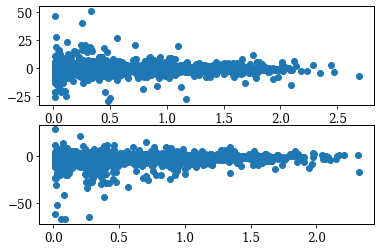

In [13]:
fig, ax = plt.subplots(2)

ax[0].scatter(df.pmra_error,df.pmra)
ax[1].scatter(df.pmdec_error,df.pmdec)

In [14]:
print(np.mean(df.pmdec), np.mean(df.pmdec_error)) ## por que pmra tem um erro muito maior?
print(np.mean(df.pmra), np.mean(df.pmra_error))

-1.4511852727093584 0.3643195629119873
-0.3071618366950593 0.4142923951148987


## Applying better conditions to the variables

In [15]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(2546, 6742)

## Dropping uknown values of pmra, pmdec or parallax.

In [16]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmdec', 'parallax'])
ndf

,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b
6,104.404439,8.086612,-0.219668,0.056068,-1.771844,0.047150,0.752697,16.324934,0.305100,0.050536,NaN,NaN,206.416996,5.042800
7,104.385444,8.089441,-28.970612,0.477947,2.691122,0.420462,2.606569,19.777077,1.980861,0.436489,NaN,NaN,206.405968,5.027276
12,104.393718,8.092030,1.262085,0.280778,-4.472053,0.245397,1.259104,19.104099,0.672170,0.257610,NaN,NaN,206.407345,5.035757
13,104.398984,8.093661,-1.082858,0.179974,-6.184319,0.185174,1.901026,18.156082,0.751489,0.148387,NaN,NaN,206.408237,5.041147
14,104.387023,8.094885,1.089377,0.103115,0.478918,0.088025,0.961241,17.512575,0.261467,0.096404,NaN,NaN,206.401792,5.031121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6736,104.411286,8.484227,-0.732358,0.098056,-5.365140,0.084469,1.567238,17.048483,0.403870,0.090321,NaN,NaN,206.063454,5.227605
6738,104.331127,8.469034,-0.701088,0.033149,-0.108907,0.027378,1.357328,15.302980,0.230631,0.031346,NaN,NaN,206.041307,5.149951
6739,104.328471,8.467142,-0.831330,0.039030,-3.054127,0.032422,0.840475,15.629803,0.457549,0.037091,NaN,NaN,206.041819,5.146754
6740,104.326157,8.466669,0.372952,0.078604,-0.343807,0.064095,0.913744,16.917267,0.212003,0.074434,NaN,NaN,206.041209,5.144496


In [17]:
#from sklearn.cluster import DBSCAN
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import v_measure_score
from sklearn.preprocessing import StandardScaler

## Creating the arrays to perform the 5-D HDBSCAN fit

In [18]:
X = np.dstack((ndf['pmra'],ndf['pmdec']))[0]
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]

In [19]:
sc = StandardScaler()

escalada = sc.fit_transform(cincoD)

## Performing the HDBSCAN

In [20]:
import hdbscan

Estimated no. of clusters: 1
Estimated no. of noise points: 1282
Estimated no. points clustered: 500


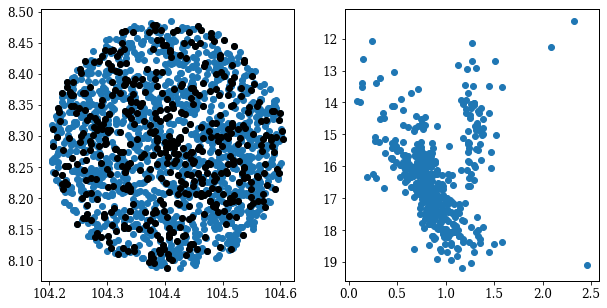

In [21]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples = 1, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(cincoD)

labels = clusterer.labels_


ndf = ndf.assign(labels=labels)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


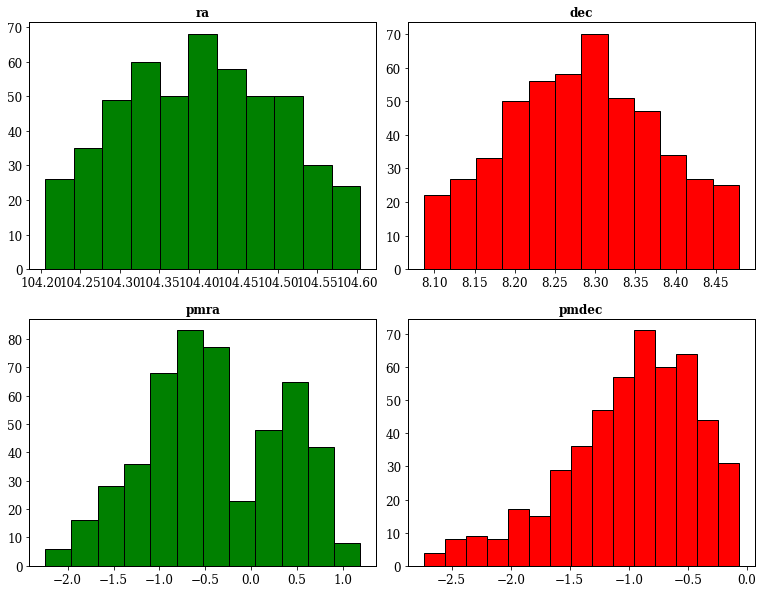

In [22]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


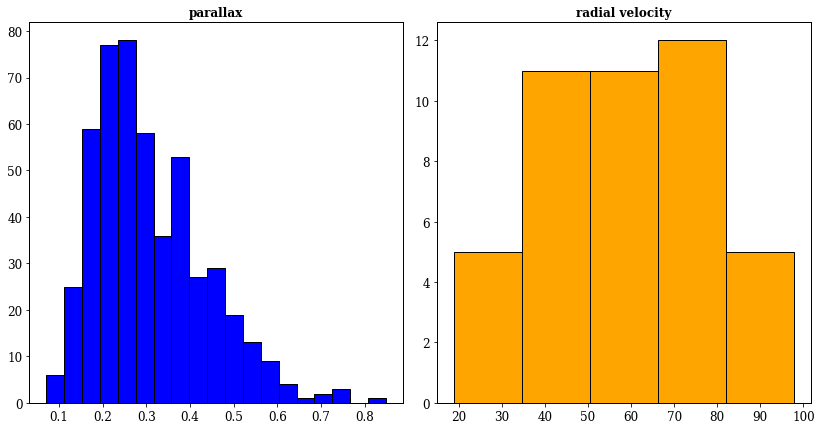

In [23]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Constructing a RDP and histograms of the clusters parameters

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

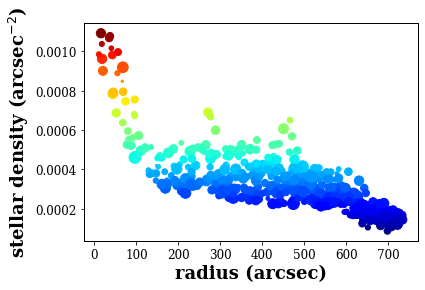

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=subset['ra']*units.degree, dec=subset['dec']*units.degree, frame='fk5')

nstar = len(subset)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([subset['ra']*np.cos(subset['dec']*np.pi/180.0), subset['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(subset['ra'], weights=den_data)
std_x = np.average((subset['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(subset['dec'], weights=den_data)
std_y = np.average((subset['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



## Gaussian fit

In [25]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 19
    # variables        = 3
    chi-square         = 1766.61439
    reduced chi-square = 110.413399
    Akaike info crit   = 92.1152436
    Bayesian info crit = 94.9485605
[[Variables]]
    amplitude:  21.6140290 +/- 1.91627318 (8.87%) (init = 25.28145)
    center:     0.25852726 +/- 0.01250621 (4.84%) (init = 0.2524805)
    sigma:      0.12559319 +/- 0.01352860 (10.77%) (init = 0.1080404)
    fwhm:       0.29574936 +/- 0.03185743 (10.77%) == '2.3548200*sigma'
    height:     68.6561934 +/- 5.80261594 (8.45%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.645
    C(center, sigma)     = -0.133
    C(amplitude, center) = -0.104


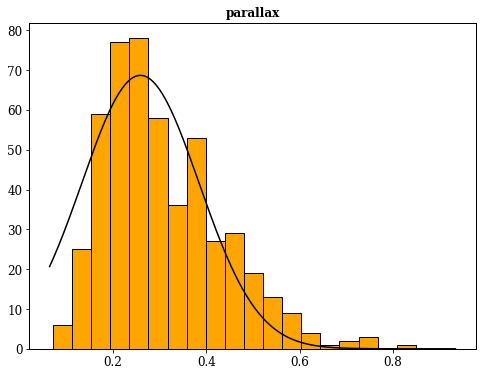

In [26]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 11
    # variables        = 3
    chi-square         = 243.665772
    reduced chi-square = 30.4582215
    Akaike info crit   = 40.0769245
    Bayesian info crit = 41.2706103
[[Variables]]
    amplitude:  23.2499973 +/- 1.31811719 (5.67%) (init = 15.80748)
    center:     104.399192 +/- 0.00830675 (0.01%) (init = 104.4049)
    sigma:      0.14942711 +/- 0.01109048 (7.42%) (init = 0.1197536)
    fwhm:       0.35187394 +/- 0.02611609 (7.42%) == '2.3548200*sigma'
    height:     62.0731243 +/- 2.85996463 (4.61%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.784


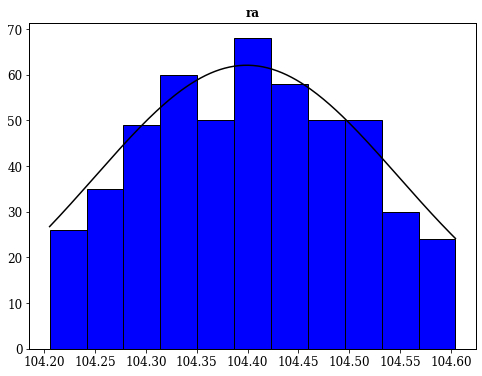

In [27]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 12
    # variables        = 3
    chi-square         = 3186.62284
    reduced chi-square = 354.069205
    Akaike info crit   = 72.9817238
    Bayesian info crit = 74.4364437
[[Variables]]
    amplitude:  167.775795 +/- 26.1247499 (15.57%) (init = 180.678)
    center:    -0.39724579 +/- 0.16992823 (42.78%) (init = -0.2441867)
    sigma:      0.98718577 +/- 0.18946999 (19.19%) (init = 0.7821557)
    fwhm:       2.32464480 +/- 0.44616773 (19.19%) == '2.3548200*sigma'
    height:     67.8016878 +/- 10.0561886 (14.83%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.654


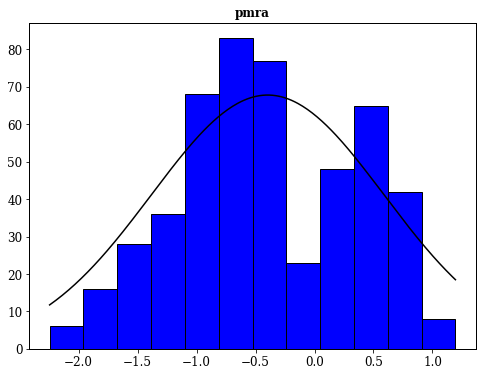

In [28]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 12
    # variables        = 3
    chi-square         = 215.508366
    reduced chi-square = 23.9453740
    Akaike info crit   = 40.6571170
    Bayesian info crit = 42.1118369
[[Variables]]
    amplitude:  19.5838888 +/- 0.89369054 (4.56%) (init = 12.82907)
    center:     8.28271021 +/- 0.00617008 (0.07%) (init = 8.282612)
    sigma:      0.12799507 +/- 0.00745233 (5.82%) (init = 0.0890908)
    fwhm:       0.30140534 +/- 0.01754890 (5.82%) == '2.3548200*sigma'
    height:     61.0401783 +/- 2.50937587 (4.11%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.712


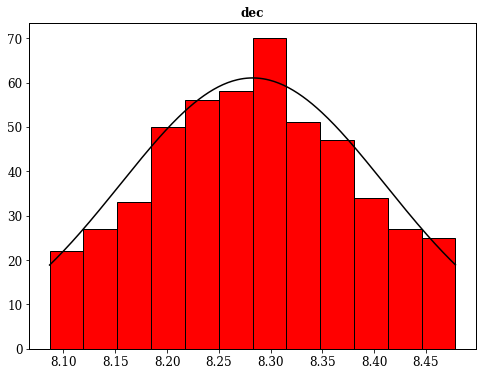

In [29]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 15
    # variables        = 3
    chi-square         = 312.503696
    reduced chi-square = 26.0419747
    Akaike info crit   = 51.5484914
    Bayesian info crit = 53.6726420
[[Variables]]
    amplitude:  103.052658 +/- 5.09918635 (4.95%) (init = 95.92451)
    center:    -0.76822599 +/- 0.03495178 (4.55%) (init = -0.7342818)
    sigma:      0.63849982 +/- 0.03919252 (6.14%) (init = 0.4772364)
    fwhm:       1.50355215 +/- 0.09229134 (6.14%) == '2.3548200*sigma'
    height:     64.3885288 +/- 2.67485704 (4.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.739
    C(center, sigma)     = 0.352
    C(amplitude, center) = 0.319


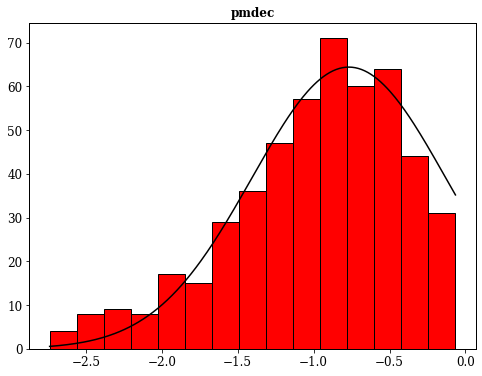

In [30]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 5
    # variables        = 3
    chi-square         = 6.48088464
    reduced chi-square = 3.24044232
    Akaike info crit   = 7.29709553
    Bayesian info crit = 6.12540927
[[Variables]]
    amplitude:  972.670695 +/- 124.497549 (12.80%) (init = 413.8428)
    center:     59.3986518 +/- 4.08077108 (6.87%) (init = 58.31332)
    sigma:      30.9061733 +/- 5.12511014 (16.58%) (init = 19.7068)
    fwhm:       72.7784750 +/- 12.0687119 (16.58%) == '2.3548200*sigma'
    height:     12.5554037 +/- 1.41503834 (11.27%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.734


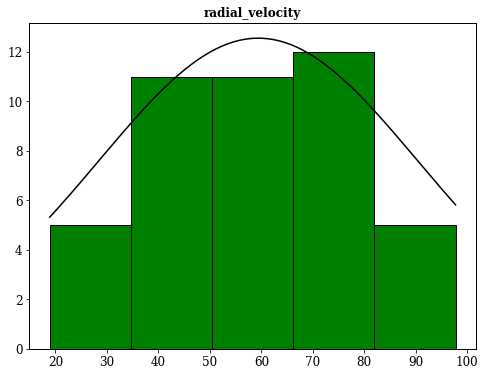

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

## Sigma Clipping

500
153


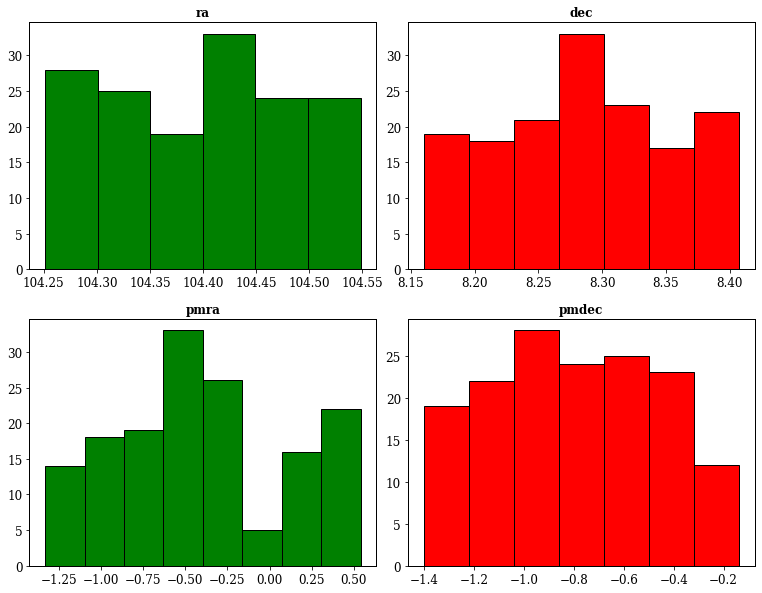

In [44]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 1

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


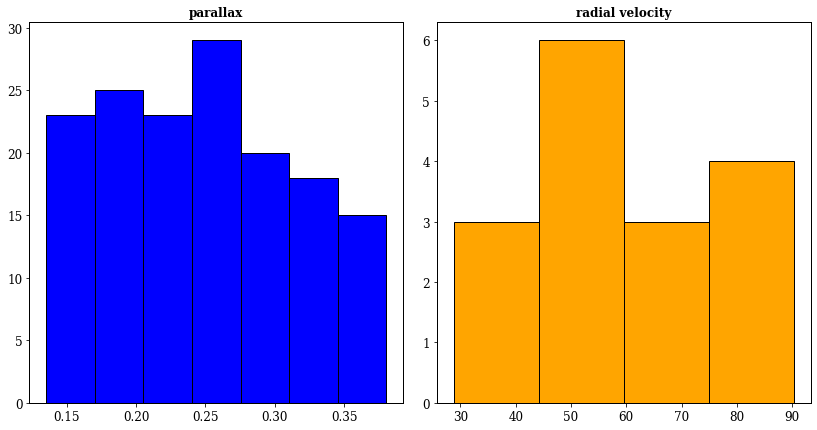

In [45]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(clip_loop['parallax'], bins = 'fd')
ax1.hist(clip_loop['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

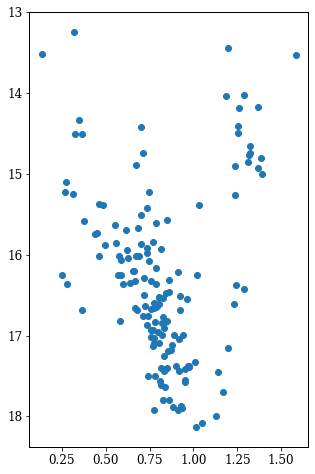

In [46]:
plt.figure(figsize=(5,8))
plt.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'])
plt.gca().invert_yaxis()

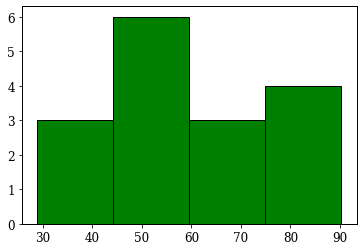

In [47]:
ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']

plt.hist(data, optimal_bin, ec = 'k',color = 'green');

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

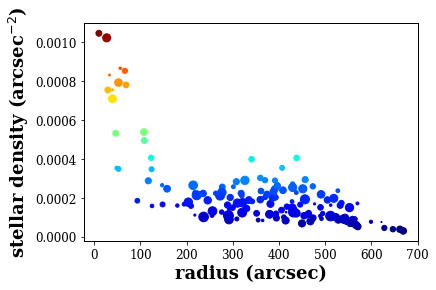

In [48]:
from astropy.coordinates import SkyCoord
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [37]:
center

<SkyCoord (ICRS): (ra, dec) in deg
    (104.39809311, 8.28915379)>

In [38]:
final = df.loc[(df.parallax < paralaxe_up ) & (df.parallax > paralaxe_down) & (df.ra>ra_down) & (df.ra<ra_up) & 
                              (df.dec>dec_down) & (df.dec<dec_up) & (df.pmra>pmra_down) & (df.pmra<pmra_up) & (df.pmdec>pmdec_down) 
                              & (df.pmdec<pmdec_up)  & (df.radial_velocity.isnull() | (df.radial_velocity>radvel_down) & (df.radial_velocity<radvel_up)) ]

In [39]:
clip_loop.to_csv('final_5d.csv', index=False)

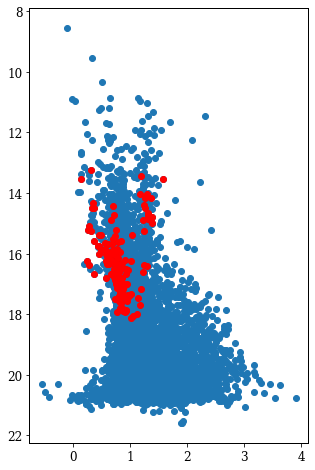

In [49]:
plt.figure(figsize=(5,8))
plt.scatter(df['bp_rp'],df['phot_g_mean_mag'])
plt.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'red')
plt.gca().invert_yaxis()

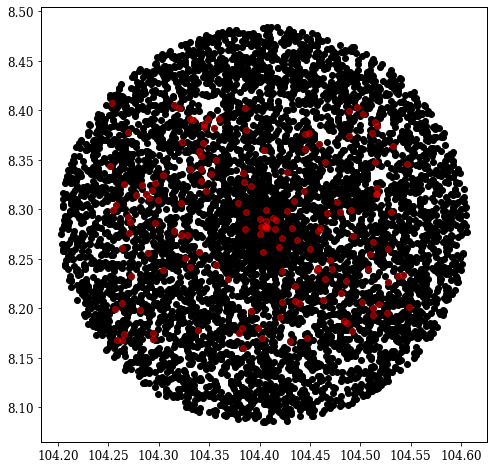

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(df['ra'],df['dec'], color = 'k')
plt.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', alpha = 0.5)